In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc

from sklearn.utils import resample

import warnings
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('semua_terpakai.csv', encoding = 'utf-16')
df['POS']= np.where(df['senti'] == 'positif', '1', '0')
df['NET']= np.where(df['senti'] == 'netral', '1', '0')
df['NEG']= np.where(df['senti'] == 'negatif', '1', '0')
df['TER']= np.where(df['level_bahasa'] == 'teratur', '1', '0')
df['SED']= np.where(df['level_bahasa'] == 'sedang', '1', '0')
df['TTE']= np.where(df['level_bahasa'] == 'tidak teratur', '1', '0')
df['IND']= np.where(df['jenis_bahasa'] == 'Indonesia_murni', '1', '0')
df['CBI']= np.where(df['jenis_bahasa'] == 'campur_bahasa_Inggris', '1', '0')
df['CBD']= np.where(df['jenis_bahasa'] == 'campur_bahasa_daerah', '1', '0')
df['ENG']= np.where(df['jenis_bahasa'] == 'Inggris_murni', '1', '0')

#y = df.balance
#X = df.drop('balance', axis=1)
df_majority = df[df.TER== '0' ]

df_minority = df[df.TER== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=840,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.TTE== '0' ]

df_minority_2 = df_upsampled[df_upsampled.TTE== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=840,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df_upsampled_2.level_bahasa.value_counts()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


sedang           840
teratur          840
tidak teratur    840
Name: level_bahasa, dtype: int64

In [2]:
df_upsampled_2.Comment=df_upsampled_2.Comment.astype(str)
df_upsampled_2

,Comment,sentiment,senti,jenis_bahasa,level_bahasa,POS,NET,NEG,TER,SED,TTE,IND,CBI,CBD,ENG
0,seni bahasa pemerintah new normal protokol kesehatan psbb,-0.143181818,negatif,campur_bahasa_Inggris,sedang,0,0,1,0,1,0,0,1,0,0
2,terserah lah mau ngomong apa pusing denger dia ngomong,-0.1,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,-0.6,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,pak jokowi yg trhormat tlog izinkn z mereka brdgang sesuai tgl gtu hri tgl gnap no tko genap bleh brdagang hri tgl gnjil lbur bgtu lh sbaliknya spy mreka tdk trllu trauma,-0.3,negatif,Indonesia_murni,tidak teratur,0,0,1,0,0,1,1,0,0,0
662,hmmm,0,netral,Indonesia_murni,tidak teratur,0,1,0,0,0,1,1,0,0,0
700,pencitraan biar gx kalah denagn anis,-0.01,negatif,Indonesia_murni,tidak teratur,0,0,1,0,0,1,1,0,0,0
44,mask masker yg digunakan perlulah dari jenis medical mask layer rata mask masker yg digunakan dlm video ni tdk menepati piawai,-0.175,negatif,Indonesia_murni,tidak teratur,0,0,1,0,0,1,1,0,0,0


In [3]:
df_=df_upsampled_2.drop(['sentiment','senti','jenis_bahasa','level_bahasa','POS','NET','NEG','IND','CBI','CBD','ENG'], axis =1)
df_

,Comment,TER,SED,TTE
0,seni bahasa pemerintah new normal protokol kesehatan psbb,0,1,0
2,terserah lah mau ngomong apa pusing denger dia ngomong,0,1,0
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,0,1,0
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,1,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,0,1,0
...,...,...,...,...
64,pak jokowi yg trhormat tlog izinkn z mereka brdgang sesuai tgl gtu hri tgl gnap no tko genap bleh brdagang hri tgl gnjil lbur bgtu lh sbaliknya spy mreka tdk trllu trauma,0,0,1
662,hmmm,0,0,1
700,pencitraan biar gx kalah denagn anis,0,0,1
44,mask masker yg digunakan perlulah dari jenis medical mask layer rata mask masker yg digunakan dlm video ni tdk menepati piawai,0,0,1


In [4]:
df_['TER']=df_['TER'].astype(int)
df_['SED']=df_['SED'].astype(int)
df_['TTE']=df_['TTE'].astype(int)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_, test_size=0.2, random_state = 23)
train

,Comment,TER,SED,TTE
353,setuju saya new normal di kasih psbb malah ramai mendingan new normal aja sekalian biar kerasa,1,0,0
915,mau usul pak pmerintah q pengn pulkam klo buat surat kok mhal hrganya q rakyat kecil pak tolong dikondosikan pak pikirkan rakyat kecil,0,1,0
141,harusnya ditambah jurus pamungkas mempercepat penyebaran covid new normal itu hanya dilakukan jika jumlah korban terpapar makin berkurang dan angka kesembuhan semakin tinggi,1,0,0
933,terserah,1,0,0
744,yang positif bertambah terus setiap harinya jumlahnya bahkan ratusan hukum rimba akan berlaku siapa yang kuat dia selamat siapa yang lemah dia tamat semoga keputusan yg bapak ambil ini tepat dan semoga kita semua selalu dalam lindungan allah swt,1,0,0
...,...,...,...,...
1418,ya allah semoga normal lagi aku dari arab saudi begitu sedih melihat negara ku dan semoga ekonomi nyah bagus lagi amiin,1,0,0
44,mask masker yg digunakan perlulah dari jenis medical mask layer rata mask masker yg digunakan dlm video ni tdk menepati piawai,0,0,1
1367,semakin ditekan saya akan semakin menjadi tunggu kalian para antek asing,1,0,0
1235,lihattt di bekassiiiii umpel nnn,0,1,0


In [6]:
list_classes = ['TER','SED','TTE']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comment"]
list_sentences_test = test["Comment"]

In [7]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

[[272, 44, 3, 2, 4, 190, 49, 160, 1263, 1548, 3, 2, 13, 968, 113, 1549]]

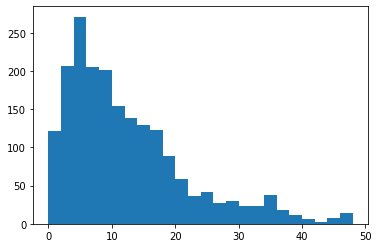

In [8]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,50,2))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [9]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [10]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [11]:


#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model300.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [12]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

3128 835
known words: 3128
unknown words: 835


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [13]:
print(emb_init_values)

[[-0.11076635 -0.05123871 -0.36495847 ... -0.7535308  -0.3139119
  -1.0396185 ]
 [ 1.4031776   0.5934335   0.40442282 ... -0.35535118  0.5263745
  -0.6059853 ]
 [ 1.9398055   0.9223579   1.1527607  ... -0.35870504 -3.8962324
  -0.5033255 ]
 ...
 [ 0.21009143  0.21169955  0.06900819 ... -0.186453   -0.22104909
   0.10568234]
 [-0.09088105  0.19126475 -0.11530017 ...  0.01135507 -0.07090043
  -0.2464576 ]
 [-0.1349479   0.06518767  0.05040589 ... -0.1708346  -0.19888364
  -0.00871246]]


In [14]:
emb_init_values.shape

(3964, 300)

In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [16]:
inp = Input(shape=(maxlen,))

In [17]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2521 entries, 0 to 833
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  2521 non-null   object
 1   TER      2521 non-null   int32 
 2   SED      2521 non-null   int32 
 3   TTE      2521 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 68.9+ KB


In [18]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

Epoch 1/100

 ROC-AUC - epoch: 1 - score: 0.847513 

63/63 - 8s - loss: 0.5933 - accuracy: 0.4816 - val_loss: 0.4725 - val_accuracy: 0.6554
Epoch 2/100

 ROC-AUC - epoch: 2 - score: 0.928886 

63/63 - 7s - loss: 0.3364 - accuracy: 0.8011 - val_loss: 0.3172 - val_accuracy: 0.7802
Epoch 3/100

 ROC-AUC - epoch: 3 - score: 0.956745 

63/63 - 7s - loss: 0.1830 - accuracy: 0.8953 - val_loss: 0.2776 - val_accuracy: 0.8337
Epoch 4/100

 ROC-AUC - epoch: 4 - score: 0.963140 

63/63 - 7s - loss: 0.0990 - accuracy: 0.9474 - val_loss: 0.2855 - val_accuracy: 0.8475
Epoch 5/100

 ROC-AUC - epoch: 5 - score: 0.965611 

63/63 - 6s - loss: 0.0418 - accuracy: 0.9826 - val_loss: 0.3027 - val_accuracy: 0.8851
Epoch 6/100

 ROC-AUC - epoch: 6 - score: 0.965479 

63/63 - 6s - loss: 0.0303 - accuracy: 0.9871 - val_loss: 0.3330 - val_accuracy: 0.8693
Epoch 7/100

 ROC-AUC - epoch: 7 - score: 0.968195 

63/63 - 7s - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.3514 - val_accuracy: 0.8970
Epoch 8/100

 ROC-AU

Epoch 59/100

 ROC-AUC - epoch: 59 - score: 0.960632 

63/63 - 7s - loss: 9.5632e-04 - accuracy: 0.9990 - val_loss: 0.8521 - val_accuracy: 0.8792
Epoch 60/100

 ROC-AUC - epoch: 60 - score: 0.956590 

63/63 - 7s - loss: 0.0014 - accuracy: 0.9990 - val_loss: 0.9115 - val_accuracy: 0.8733
Epoch 61/100

 ROC-AUC - epoch: 61 - score: 0.959994 

63/63 - 6s - loss: 0.0010 - accuracy: 0.9985 - val_loss: 0.9156 - val_accuracy: 0.8634
Epoch 62/100

 ROC-AUC - epoch: 62 - score: 0.959382 

63/63 - 6s - loss: 0.0016 - accuracy: 0.9990 - val_loss: 0.9176 - val_accuracy: 0.8752
Epoch 63/100

 ROC-AUC - epoch: 63 - score: 0.956259 

63/63 - 6s - loss: 0.0013 - accuracy: 0.9990 - val_loss: 0.9612 - val_accuracy: 0.8713
Epoch 64/100

 ROC-AUC - epoch: 64 - score: 0.958147 

63/63 - 6s - loss: 0.0011 - accuracy: 0.9990 - val_loss: 0.9540 - val_accuracy: 0.8733
Epoch 65/100

 ROC-AUC - epoch: 65 - score: 0.956117 

63/63 - 6s - loss: 0.0014 - accuracy: 0.9990 - val_loss: 0.9758 - val_accuracy: 0.8713
Ep

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           1189200   
_________________________________________________________________
gru (GRU)                    (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [20]:
from keras.models import load_model
c = model.predict(X_te)
c

array([[1.0000000e+00, 3.4636287e-12, 8.3083412e-15],
       [1.5684925e-23, 1.3356452e-13, 1.0000000e+00],
       [1.0000000e+00, 1.3776576e-08, 2.2881119e-10],
       ...,
       [3.6704506e-14, 1.0000000e+00, 6.4952731e-15],
       [1.5563828e-10, 1.0000000e+00, 4.3533846e-10],
       [1.0000000e+00, 1.6727952e-11, 1.2980280e-13]], dtype=float32)

In [21]:
df_.describe()

,TER,SED,TTE
count,2521.000000,2521.000000,2521.000000
mean,0.333201,0.333201,0.333201
std,0.471451,0.471451,0.471451
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [22]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 0s 22ms/step - loss: 1.0697 - accuracy: 0.8713
Test accuracy: 0.8712871074676514


In [23]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9593506773793298

In [24]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

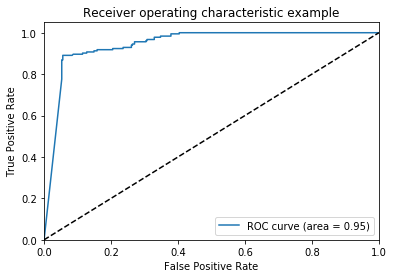

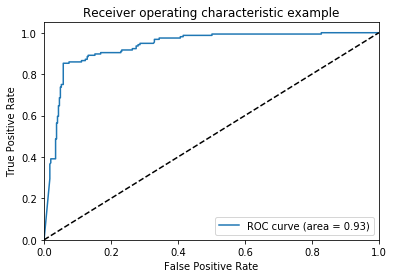

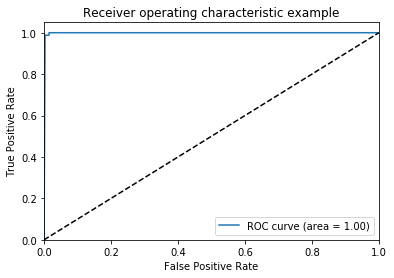

In [25]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
y_pred

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [27]:
roc_auc_score(y_te, y_pred)

0.9044058385919277

In [28]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[281  41]
  [ 17 166]]

 [[332  17]
  [ 42 114]]

 [[327  12]
  [  0 166]]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       183
           1       0.87      0.73      0.79       156
           2       0.93      1.00      0.97       166

   micro avg       0.86      0.88      0.87       505
   macro avg       0.87      0.88      0.87       505
weighted avg       0.87      0.88      0.87       505
 samples avg       0.87      0.88      0.88       505



In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [30]:
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))

Hamming score: 0.8735973597359736


In [31]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.8653465346534653
Hamming loss: 0.08514851485148515


In [32]:
X_t[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  272,   44,    3,    2,    4,  190,   49,  160, 1263, 1548,
           3,    2,   13,  968,  113, 1549],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   25, 1550,   29, 1551,  473, 2078,
        1264,   78,   92, 1265,  191, 2079, 2080,  473,    9,  101,   29,
         362, 2081,   29, 1552,    9,  101]])

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)) 

array([[166,  16,   1],
       [ 41, 110,   5],
       [  0,   0, 166]], dtype=int64)

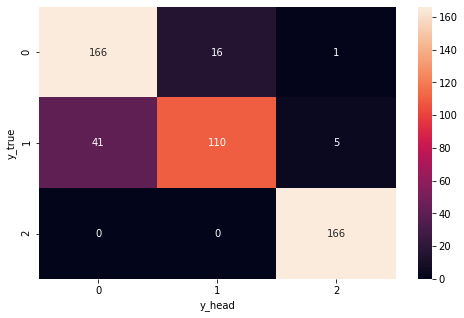

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()